In [1]:
!pip install beautifulsoup4
!pip install requests
!pip install vaderSentiment
!pip install textblob
!pip install flair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 53.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 9.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-man

### **Importing libraries**

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import time
import re
import nltk
from nltk.stem import WordNetLemmatizer
from collections import Counter

nltk.download('stopwords')
nltk.download('wordnet')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from flair.models import TextClassifier
from flair.data import Sentence
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **Scraping**

The first step is to scrape reviews from Skytrax website, explicitly focusing on Royal Air Maroc.

The scraped data includes:


*   Review written by each customer
*   Rating given by each customer

I used BeautifulSoup library to collect the links to the reviews and then to collect the text data on each of the individual review links.

In [3]:
base_url = "https://www.airlinequality.com/airline-reviews/royal-air-maroc"
pages = 38
page_size = 10
reviews = []
ratings = []

for i in range(1, pages + 1):
    print(f"Scraping page {i}")

    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    try:
        response = requests.get(url)
        if response.status_code == 200:
            content = response.content
            parsed_content = BeautifulSoup(content, 'html.parser')
            review_divs = parsed_content.find_all("div", class_="text_content")
            rating_divs = parsed_content.find_all("div", class_="rating-10")
            if review_divs:
                for idx, div in enumerate(review_divs):
                    review_text = div.get_text(strip=True)
                    rating_value = rating_divs[idx].get_text(strip=True)
                    reviews.append(review_text)
                    ratings.append(rating_value)
                print(f"   ---> {len(reviews)} total reviews")
            else:
                print("No reviews found on this page.")
        else:
            print(f"Failed to retrieve page {i}. Status code: {response.status_code}")

    except Exception as e:
        print(f"Error occurred while processing page {i}: {e}")

print("Scraping completed.")

Scraping page 1
   ---> 10 total reviews
Scraping page 2
   ---> 20 total reviews
Scraping page 3
   ---> 30 total reviews
Scraping page 4
   ---> 40 total reviews
Scraping page 5
   ---> 50 total reviews
Scraping page 6
   ---> 60 total reviews
Scraping page 7
   ---> 70 total reviews
Scraping page 8
   ---> 80 total reviews
Scraping page 9
   ---> 90 total reviews
Scraping page 10
   ---> 100 total reviews
Scraping page 11
   ---> 110 total reviews
Scraping page 12
   ---> 120 total reviews
Scraping page 13
   ---> 130 total reviews
Scraping page 14
   ---> 140 total reviews
Scraping page 15
   ---> 150 total reviews
Scraping page 16
   ---> 160 total reviews
Scraping page 17
   ---> 170 total reviews
Scraping page 18
   ---> 180 total reviews
Scraping page 19
   ---> 190 total reviews
Scraping page 20
   ---> 200 total reviews
Scraping page 21
   ---> 210 total reviews
Scraping page 22
   ---> 220 total reviews
Scraping page 23
   ---> 230 total reviews
Scraping page 24
   ---> 240 

There are **349 reviews** for Royal Air Maroc on the website.

### **Loading the scraped data into a DataFrame**

In [4]:
# Create a DataFrame with review text and rating columns
df = pd.DataFrame({"Review": reviews, "Rating": ratings})

# Save the DataFrame to a CSV file
df.to_csv("RAM_reviews.csv", index=False)

In [5]:
df.head()

,Review,Rating
0,✅Trip Verified| Very smooth check-in at Casabl...,4/10
1,✅Trip Verified| Royal Air Maroc is bar none t...,7/10
2,Not Verified| There is a need for an upgrade i...,10/10
3,"Not Verified| This is, without doubt, the wor...",2/10
4,✅Trip Verified| London Heathrow to Roberts in...,3/10


# **Data Cleaning**

I started by removing any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed (if it exists in the row), as it's not relevant to what we want to investigate.

In [6]:
ram_data = pd.read_csv('RAM_reviews.csv')

In [7]:
def clean_review(review):
    # Remove "✅ Trip Verified" if it exists
    review = review.replace("✅Trip Verified|", "")
    # Remove "Not Verified" if it exists
    review = review.replace("Not Verified|", "")
    # Strip leading and trailing whitespaces
    review = review.strip()
    return review

# Apply the clean_review function to the 'Review' column in ram_data
ram_data['cleaned_reviews'] = ram_data['Review'].apply(clean_review)

# Display the cleaned data
print(ram_data[['Review', 'cleaned_reviews']])

                                                Review  \
0    ✅Trip Verified| Very smooth check-in at Casabl...   
1    ✅Trip Verified|  Royal Air Maroc is bar none t...   
2    Not Verified| There is a need for an upgrade i...   
3    Not Verified|  This is, without doubt, the wor...   
4    ✅Trip Verified|  London Heathrow to Roberts in...   
..                                                 ...   
346  Of the 6 flights (2 international and 4 domest...   
347  Marrakech to LHR via Casablanca. Check in smoo...   
348  This is the most unorganized air line I have e...   
349  My wife and I flew with this airline from Lond...   
350  Have had an awful experience with this airline...   

                                       cleaned_reviews  
0    Very smooth check-in at Casablanca though secu...  
1    Royal Air Maroc is bar none the best airline I...  
2    There is a need for an upgrade in the seats as...  
3    This is, without doubt, the worst airline I ha...  
4    London Heathr

In [8]:
ram_data.head()

,Review,Rating,cleaned_reviews
0,✅Trip Verified| Very smooth check-in at Casabl...,4/10,Very smooth check-in at Casablanca though secu...
1,✅Trip Verified| Royal Air Maroc is bar none t...,7/10,Royal Air Maroc is bar none the best airline I...
2,Not Verified| There is a need for an upgrade i...,10/10,There is a need for an upgrade in the seats as...
3,"Not Verified| This is, without doubt, the wor...",2/10,"This is, without doubt, the worst airline I ha..."
4,✅Trip Verified| London Heathrow to Roberts in...,3/10,London Heathrow to Roberts international Monro...


Further cleaning : removing special and unnecessary characters and stopwords, converting to lowercase...

In [9]:
# Function to clean the text
def clean_text(text):
    # Remove special characters, numbers, and unnecessary whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # Split the text into words and filter out stopwords
    cleaned_text = ' '.join(word for word in text.split() if word not in stop_words)
    return cleaned_text

In [10]:
ram_data['cleaned_reviews'] = ram_data['cleaned_reviews'].apply(clean_text)
ram_data.head()

,Review,Rating,cleaned_reviews
0,✅Trip Verified| Very smooth check-in at Casabl...,4/10,smooth checkin casablanca though security pass...
1,✅Trip Verified| Royal Air Maroc is bar none t...,7/10,royal air maroc bar none best airline ive ever...
2,Not Verified| There is a need for an upgrade i...,10/10,need upgrade seats comfortable additionally to...
3,"Not Verified| This is, without doubt, the wor...",2/10,without doubt worst airline ever flown changed...
4,✅Trip Verified| London Heathrow to Roberts in...,3/10,london heathrow roberts international monrovia...


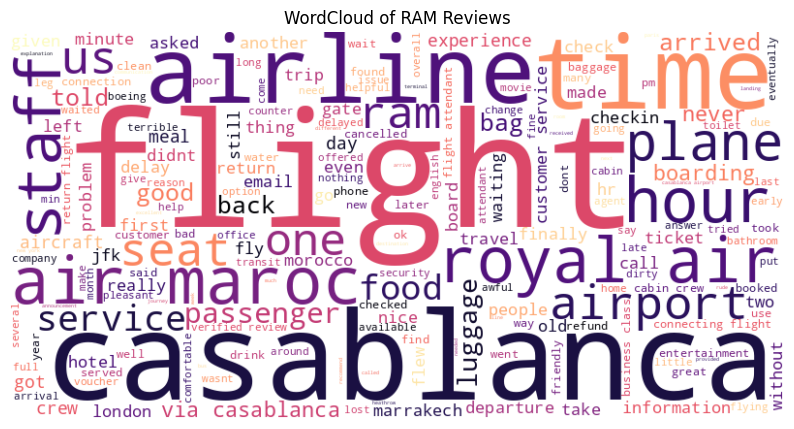

In [11]:
# Combine all reviews into a single string
all_reviews = ' '.join(ram_data['cleaned_reviews'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, colormap='magma', collocations=True, background_color='white').generate(all_reviews)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of RAM Reviews')
plt.show()

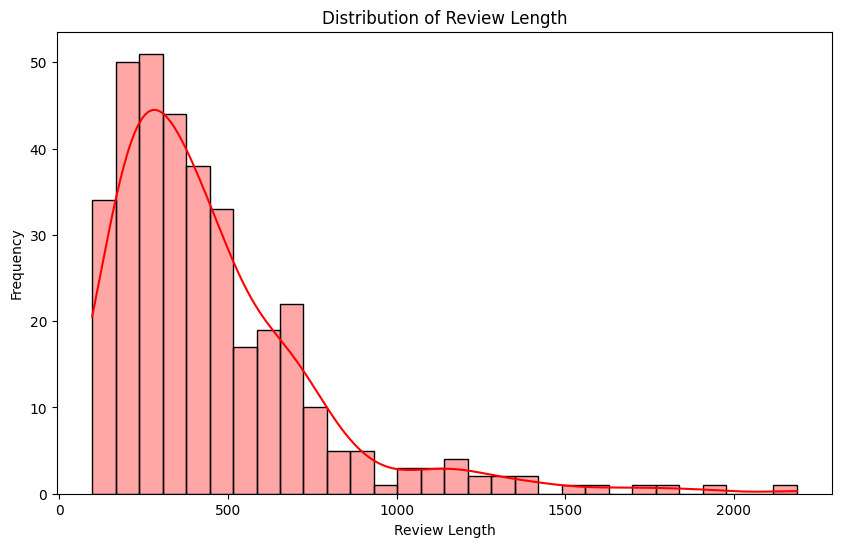

In [12]:
# Plot the review length distribution
plt.figure(figsize=(10, 6))
sns.histplot(ram_data['cleaned_reviews'].apply(len), color='r', bins=30, kde=True, alpha=0.35)
plt.title('Distribution of Review Length')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

<ipython-input-13-7f7d77bdfd1d>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


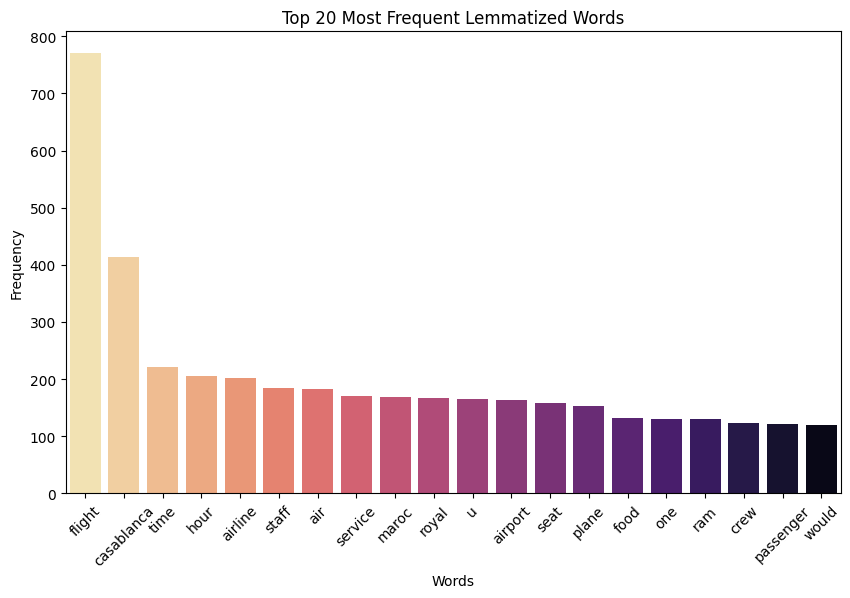

In [13]:
# Lemmatize the words
def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
    return ' '.join(lemmatized_words)

# Tokenize and lemmatize the cleaned reviews into individual words
words = ' '.join(lemmatize_words(review) for review in ram_data['cleaned_reviews']).split()

# Count the frequency of each lemmatized word
lemmatized_word_freq = Counter(words)

# Get the top 20 most frequent lemmatized words
top_20_lemmatized_words = lemmatized_word_freq.most_common(20)

# Plot the top 20 frequent lemmatized words
plt.figure(figsize=(10, 6))
sns.barplot(
    x=[word[0] for word in top_20_lemmatized_words],
    y=[word[1] for word in top_20_lemmatized_words],
    palette="magma_r"
)
plt.title('Top 20 Most Frequent Lemmatized Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [14]:
ram_data.to_csv("RAM_cleaned_reviews.csv")